In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('words.txt','r').read().splitlines()
words[-10:-3]

['Zwinglianism',
 'Zwinglianist',
 'zwitter',
 'zwitterion',
 'zwitterionic',
 'Zwolle',
 'Zworykin']

In [3]:
len(words)

466550

In [4]:
chars = sorted(list(set((''.join(words)).lower())))
chars[0], chars[5] = chars[5], chars[0]
# chars.insert(0,'.')
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
print(itos)

{0: '.', 1: '&', 2: "'", 3: ',', 4: '-', 5: '!', 6: '/', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: 'a', 18: 'b', 19: 'c', 20: 'd', 21: 'e', 22: 'f', 23: 'g', 24: 'h', 25: 'i', 26: 'j', 27: 'k', 28: 'l', 29: 'm', 30: 'n', 31: 'o', 32: 'p', 33: 'q', 34: 'r', 35: 's', 36: 't', 37: 'u', 38: 'v', 39: 'w', 40: 'x', 41: 'y', 42: 'z'}


In [5]:
block_size = 10
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w.lower() + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
    
X = torch.tensor(X)
Y = torch.tensor(Y)

In [32]:
neurons = 300
embDims = 5

C = torch.randn((len(itos),embDims))
W1 = torch.randn((embDims*block_size,neurons)) * 0.01
b1 = torch.randn(neurons)* 0.01
W2 = torch.randn((neurons,len(itos))) * 0.01
b2 = torch.randn(len(itos)) * 0
params = [C,W1,b1,W2,b2]
len(itos)

43

In [33]:
for p in params:
    p.requires_grad = True

In [34]:
lrexp = torch.linspace(-1, -0.1, 1000)
lrs = 10**lrexp

In [35]:
def get_loss():
    emb = C[X] #32x3x2
    h = torch.tanh(emb.view(emb.shape[0],embDims*block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y)
    return loss.item()

In [68]:
# lri = []
lossi = []
n = 200000
for i in range(n):
    
    #forward pass
    ix = torch.randint(0,X.shape[0], (2048,))
    small = X[ix]
    emb = C[small]
    h = torch.tanh(emb.view(emb.shape[0],embDims*block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y[ix])
    
    #backward pass
    for p in params:
        p.grad = None
    loss.backward()
    lr = 0.005
    if( i % (n/10) == 0):
        emb = C[X] #32x3x2
        print( i, "->", loss.item())
        
    #update
    for p in params:
        p.data += -lr * p.grad
        
print( get_loss() )

0 -> 2.1931028366088867
20000 -> 2.2119288444519043
40000 -> 2.15006160736084
60000 -> 2.1512451171875
80000 -> 2.213310480117798
100000 -> 2.1511640548706055
120000 -> 2.1980509757995605
140000 -> 2.1388823986053467
160000 -> 2.1268646717071533
180000 -> 2.195040702819824
2.157731771469116


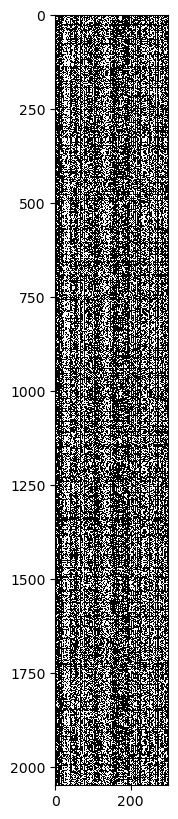

In [69]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = "gray", interpolation='nearest')

(array([32372.,  7040.,  4407.,  3175.,  2614.,  2283.,  2079.,  1547.,
         1375.,  1220.,  1279.,  1152.,   992.,  1129.,   957.,   946.,
          871.,   910.,   872.,   819.,   776.,   665.,   637.,   613.,
          602.,   539.,   533.,   577.,   558.,   478.,   485.,   461.,
          456.,   534.,   440.,   511.,   563.,   447.,   499.,   439.,
          399.,   447.,   420.,   465.,   428.,   410.,   458.,   492.,
          482.,   381.,   464.,   564.,   445.,   435.,   420.,   440.,
          471.,   475.,   491.,   503.,   426.,   487.,   475.,   433.,
          440.,   478.,   476.,   468.,   573.,   529.,   479.,   444.,
          610.,   502.,   523.,   590.,   647.,   623.,   609.,   758.,
          714.,   648.,   623.,   889.,   745.,   748.,   939.,   882.,
          859.,  1096.,  1198.,  1320.,  1537.,  1625.,  1831.,  2398.,
         2828.,  3704.,  5382., 25122.]),
 array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
        -0.82, -0.8 , -

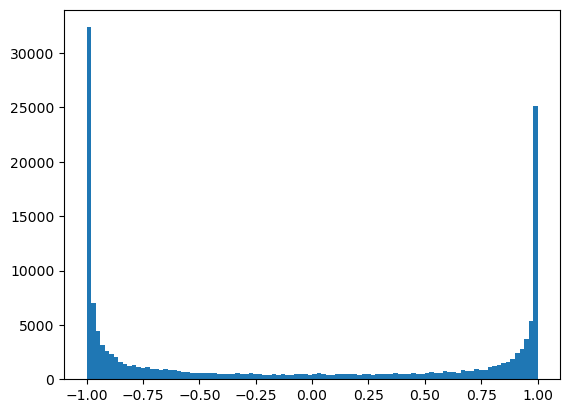

In [50]:
plt.hist(h.view(-1).tolist(), 100)

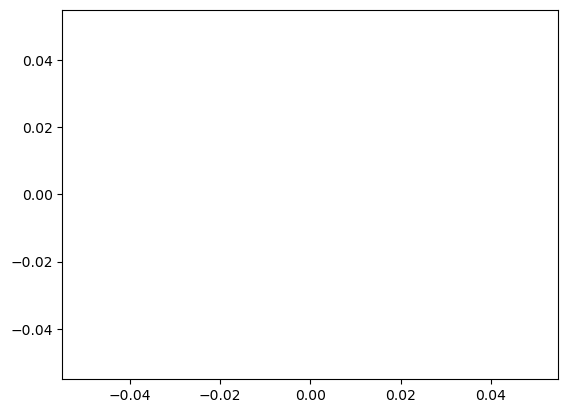

In [1506]:
plt.plot(lri,lossi)

In [51]:
emb = C[X] #32x3x2
h = torch.tanh(emb.view(emb.shape[0],embDims*block_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y)
loss.item()

KeyboardInterrupt: 

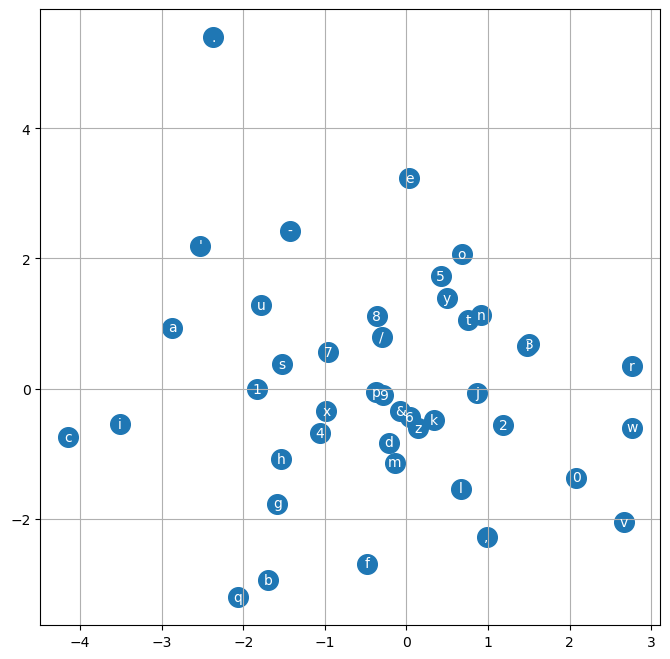

In [225]:
n, m = 2, 4

plt.figure(figsize=(8,8))
plt.scatter(C[:,n].data,C[:,m].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,n].item(), C[i,m].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [22]:
def generate_name(start_context=None, max_length=10):
    if start_context is None:
        start_context = [0] * block_size  # Start with an empty context
    else:
        start_context = [stoi[ch] for ch in start_context]

    context = start_context
    generated_name = [itos[s] for s in start_context if s != 0]
    for _ in range(max_length):
        # Create the input tensor from the current context
        context_tensor = torch.tensor(context).unsqueeze(0)  # shape (1, block_size)
        emb = C[context_tensor]  # shape (1, block_size, 2)
        
        # Forward pass
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
        logits = h @ W2 + b2
        
        # Softmax to get probabilities
        probs = F.softmax(logits, dim=-1)
        
        # Sample from the distribution
        next_char_index = torch.multinomial(probs, num_samples=1).item()
        
        # Append the generated character to the result
        generated_name.append(itos[next_char_index])
        
        # Update the context
        context = context[1:] + [next_char_index]
        
        # Terminate if the generated character is the period
        if itos[next_char_index] == '.':
            break

    return ''.join(generated_name)


In [220]:
inp = ""
inp = inp.rjust(block_size, ".")
for i in range(1):
    
    print(f'{i+1:4d}',". ", generate_name(start_context=list(inp)))

   1 .  tomniatele
